<a href="https://colab.research.google.com/github/hyomee2/scooter-parking-detector/blob/main/models/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## 1. tensorflow 설치

In [ ]:
!pip install tensorflow

## cnn 학습을 위한 디렉토리 구조 생성. (현재는 mobilenet 학습 시 디렉토리 구조를 생성했으므로 실행x)

In [ ]:
import os
import shutil
import random
from math import floor

# 수정된 경로: 모두 Google Drive 내에서 작업
original_base = '/content/gdrive/MyDrive/scooter-parking-detector/dataset/cnn'
combined_temp = '/content/gdrive/MyDrive/scooter-parking-detector/dataset/cnn_2stages/_temp_combined'
new_base = '/content/gdrive/MyDrive/scooter-parking-detector/dataset/cnn_2stages'

splits = ["train", "val", "test"]
class_names = ['improper', 'proper', 'noise']
random.seed(42)

# cnn 데이터셋 통합 후 재분할 준비
# combined_temp 폴더 초기화 및 생성
if os.path.exists(combined_temp):
    shutil.rmtree(combined_temp)
os.makedirs(combined_temp, exist_ok=True)

for cls in class_names:
    os.makedirs(os.path.join(combined_temp, cls), exist_ok=True)
    for split in splits:
        src = os.path.join(original_base, split, cls)
        if os.path.exists(src):
            for f in os.listdir(src):
                src_path = os.path.join(src, f)
                if os.path.isfile(src_path):
                    # 원본 split 정보를 파일명에 붙여서 저장 (ex: train_abc.jpg)
                    shutil.copy(src_path, os.path.join(combined_temp, cls, f"{split}_{f}"))

print("✅ CNN 데이터셋 통합 완료!")

# 재분할 및 stage별 폴더 생성 함수
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def split_and_copy(src_dir, dst_map, ratios):
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    random.shuffle(files)
    total = len(files)
    train_end = floor(ratios[0] * total)
    val_end = train_end + floor(ratios[1] * total)

    for i, phase in enumerate(['train', 'val', 'test']):
        phase_files = files[:train_end] if phase == 'train' else \
                      files[train_end:val_end] if phase == 'val' else \
                      files[val_end:]
        dst_dir = dst_map[phase]
        ensure_dir(dst_dir)
        for fname in phase_files:
            shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

# stage1 / stage2 클래스 매핑
stage1_map = {
    'noise': '0_no_kickboard',
    'improper': '1_has_kickboard',
    'proper': '1_has_kickboard'
}

stage2_map = {
    'improper': '0_improper',
    'proper': '2_proper'
}

# stage별 분할 및 저장
for cls in class_names:
    src_dir = os.path.join(combined_temp, cls)

    # Stage 1 (noise 포함)
    dst_stage1 = {
        'train': os.path.join(new_base, 'stage1', 'train', stage1_map[cls]),
        'val': os.path.join(new_base, 'stage1', 'val', stage1_map[cls]),
        'test': os.path.join(new_base, 'stage1', 'test', stage1_map[cls])
    }
    split_and_copy(src_dir, dst_stage1, ratios=(0.8, 0.1, 0.1))

    # Stage 2 (noise 제외)
    if cls != 'noise':
        dst_stage2 = {
            'train': os.path.join(new_base, 'stage2', 'train', stage2_map[cls]),
            'val': os.path.join(new_base, 'stage2', 'val', stage2_map[cls]),
            'test': os.path.join(new_base, 'stage2', 'test', stage2_map[cls])
        }
        split_and_copy(src_dir, dst_stage2, ratios=(0.8, 0.1, 0.1))

print("✅ stage1, stage2 데이터셋 분할 및 생성 완료!")

KeyboardInterrupt: 

## 2. 이상 이미지 제거

In [ ]:
import os

def clean_dataset(directory):
    valid_exts = ['.jpg', '.jpeg', '.png']
    removed_files = []

    for root, _, files in os.walk(directory):
        for fname in files:
            ext = os.path.splitext(fname)[-1].lower()
            if ext not in valid_exts:
                file_path = os.path.join(root, fname)
                removed_files.append(file_path)
                os.remove(file_path)

    return removed_files

# 데이터셋 경로 정리
removed = clean_dataset('/content/gdrive/MyDrive/scooter-parking-detector/dataset/cnn_2stages')
print(f"✅ 삭제된 비이미지 파일 개수: {len(removed)}")


✅ 삭제된 비이미지 파일 개수: 0


In [ ]:
from PIL import Image

def clean_corrupted_images(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for fname in files:
            ext = os.path.splitext(fname)[-1].lower()
            if ext in ['.jpg', '.jpeg', '.png']:
                fpath = os.path.join(root, fname)
                try:
                    img = Image.open(fpath)
                    img.verify()  # 파일이 진짜 이미지인지 검사
                except Exception:
                    corrupted.append(fpath)
                    os.remove(fpath)
    return corrupted

# 실제 이미지 열어서 검사
bad_files = clean_corrupted_images('/content/gdrive/MyDrive/scooter-parking-detector/dataset/cnn_2stages')
print(f"🧹 삭제된 손상된 이미지 파일 개수: {len(bad_files)}")


🧹 삭제된 손상된 이미지 파일 개수: 0


## 3. 모델 학습

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
import os

# ✅ 경로 설정
base_path = '/content/gdrive/MyDrive/scooter-parking-detector/dataset/cnn_2stages'
stage1_train = os.path.join(base_path, 'stage1', 'train')
stage1_val = os.path.join(base_path, 'stage1', 'val')
stage2_train = os.path.join(base_path, 'stage2', 'train')
stage2_val = os.path.join(base_path, 'stage2', 'val')

# ✅ 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Stage 1: 킥보드 유무 이진 분류
train_gen_1 = datagen.flow_from_directory(stage1_train, target_size=(224, 224), batch_size=32, class_mode='binary')
val_gen_1 = val_datagen.flow_from_directory(stage1_val, target_size=(224, 224), batch_size=32, class_mode='binary')

base_model_1 = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x1 = GlobalAveragePooling2D()(base_model_1.output)
out1 = Dense(1, activation='sigmoid')(x1)
model_1 = Model(inputs=base_model_1.input, outputs=out1)

for layer in base_model_1.layers[:-30]:
    layer.trainable = False

model_1.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=[AUC(name='auc')])

callbacks_1 = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, mode='max'),
    ModelCheckpoint('/content/gdrive/MyDrive/scooter-parking-detector/models/result/resnet/best_stage1_resnet50.h5',
                    monitor='val_auc', save_best_only=True, mode='max')
]

print("\n🔹 Stage 1 (ResNet50) 학습 시작")
history_1 = model_1.fit(train_gen_1, validation_data=val_gen_1, epochs=50, callbacks=callbacks_1)

Found 871 images belonging to 2 classes.
Found 108 images belonging to 2 classes.

🔹 Stage 1 (ResNet50) 학습 시작
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - auc: 0.5955 - loss: 0.5646

28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - auc: 0.5990 - loss: 0.5592 - val_auc: 0.5290 - val_loss: 1.1270 - learning_rate: 1.0000e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - auc: 0.8062 - loss: 0.3080

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 800ms/step - auc: 0.8077 - loss: 0.3070 - val_auc: 0.6029 - val_loss: 0.9705 - learning_rate: 1.0000e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 817ms/step - auc: 0.9029 - loss: 0.2481 - val_auc: 0.5964 - val_loss: 0.8180 - learning_rate: 1.0000e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - auc: 0.9080 - loss: 0.2230

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 832ms/step - auc: 0.9076 - loss: 0.2233 - val_auc: 0.6412 - val_loss: 0.7259 - learning_rate: 1.0000e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - auc: 0.9165 - loss: 0.2107

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 871ms/step - auc: 0.9165 - loss: 0.2109 - val_auc: 0.8154 - val_loss: 0.5857 - learning_rate: 1.0000e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - auc: 0.8687 - loss: 0.2259

28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 887ms/step - auc: 0.8700 - loss: 0.2256 - val_auc: 0.8778 - val_loss: 0.4446 - learning_rate: 1.0000e-05
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - auc: 0.9503 - loss: 0.1975

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 876ms/step - auc: 0.9501 - loss: 0.1973 - val_auc: 0.9176 - val_loss: 0.3288 - learning_rate: 1.0000e-05
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - auc: 0.9328 - loss: 0.1917

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 865ms/step - auc: 0.9331 - loss: 0.1915 - val_auc: 0.9237 - val_loss: 0.2950 - learning_rate: 1.0000e-05
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - auc: 0.9478 - loss: 0.1761

28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 957ms/step - auc: 0.9474 - loss: 0.1766 - val_auc: 0.9240 - val_loss: 0.2704 - learning_rate: 1.0000e-05
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - auc: 0.9576 - loss: 0.1561

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 894ms/step - auc: 0.9570 - loss: 0.1568 - val_auc: 0.9427 - val_loss: 0.2539 - learning_rate: 1.0000e-05
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 818ms/step - auc: 0.9406 - loss: 0.1714 - val_auc: 0.9380 - val_loss: 0.2301 - learning_rate: 1.0000e-05
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - auc: 0.9373 - loss: 0.1760

28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 913ms/step - auc: 0.9372 - loss: 0.1763 - val_auc: 0.9534 - val_loss: 0.2256 - learning_rate: 1.0000e-05
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - auc: 0.9692 - loss: 0.1539

28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 859ms/step - auc: 0.9686 - loss: 0.1544 - val_auc: 0.9599 - val_loss: 0.2397 - learning_rate: 1.0000e-05
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 847ms/step - auc: 0.9566 - loss: 0.1564 - val_auc: 0.9484 - val_loss: 0.2224 - learning_rate: 1.0000e-05
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 746ms/step - auc: 0.9644 - loss: 0.1529 - val_auc: 0.9502 - val_loss: 0.2221 - learning_rate: 1.0000e-05
Epoch 16/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - auc: 0.9377 - loss: 0.1344

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 816ms/step - auc: 0.9387 - loss: 0.1351 - val_auc: 0.9631 - val_loss: 0.1908 - learning_rate: 1.0000e-05
Epoch 17/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 828ms/step - auc: 0.9286 - loss: 0.1815 - val_auc: 0.9613 - val_loss: 0.2195 - learning_rate: 1.0000e-05
Epoch 18/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - auc: 0.9772 - loss: 0.1263

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 803ms/step - auc: 0.9769 - loss: 0.1272 - val_auc: 0.9649 - val_loss: 0.1983 - learning_rate: 1.0000e-05
Epoch 19/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 840ms/step - auc: 0.9674 - loss: 0.1392 - val_auc: 0.9466 - val_loss: 0.2193 - learning_rate: 1.0000e-05
Epoch 20/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - auc: 0.9731 - loss: 0.1223

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 790ms/step - auc: 0.9732 - loss: 0.1225 - val_auc: 0.9767 - val_loss: 0.1671 - learning_rate: 1.0000e-05
Epoch 21/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 801ms/step - auc: 0.9739 - loss: 0.1307 - val_auc: 0.9645 - val_loss: 0.1802 - learning_rate: 1.0000e-05
Epoch 22/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 695ms/step - auc: 0.9782 - loss: 0.1115 - val_auc: 0.9276 - val_loss: 0.2174 - learning_rate: 1.0000e-05
Epoch 23/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 697ms/step - auc: 0.9673 - loss: 0.1455 - val_auc: 0.9448 - val_loss: 0.2386 - learning_rate: 1.0000e-05
Epoch 24/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - auc: 0.9760 - loss: 0.1419 - val_auc: 0.9606 - val_loss: 0.1807 - learning_rate: 5.0000e-06
Epoch 25/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 697ms/step - auc: 0.9883 - loss: 0.1013 - val_auc: 0.9509 - val_loss: 0.1813 - learning_rate: 5.0000e-06
Found 751 images belonging to 2 classes.
Found 93 images belonging to 2 classes.

🔹 Stage 2 (ResNet50) 학습 시작
Epoch 1/50
24/2

24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - auc: 0.4050 - loss: 1.7283 - val_auc: 0.6527 - val_loss: 0.6489 - learning_rate: 1.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 637ms/step - auc: 0.6283 - loss: 1.2724 - val_auc: 0.6400 - val_loss: 0.6697 - learning_rate: 1.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 633ms/step - auc: 0.7390 - loss: 1.0118 - val_auc: 0.5701 - val_loss: 0.6869 - learning_rate: 1.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 655ms/step - auc: 0.7676 - loss: 0.9837 - val_auc: 0.4429 - val_loss: 0.7194 - learning_rate: 1.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 634ms/step - auc: 0.7984 - loss: 0.9054 - val_auc: 0.4289 - val_loss: 0.7410 - learning_rate: 5.0000e-06
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 637ms/step - auc: 0.8269 - loss: 0.8794 - val_auc: 0.4851 - val_loss: 0.7119 - learning_rate: 5.0000e-06


In [ ]:


# ✅ Stage 2: 적절 vs 부적절
train_gen_2 = datagen.flow_from_directory(
    stage2_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_gen_2 = val_datagen.flow_from_directory(
    stage2_val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ 클래스 가중치 설정
class_weight_2 = {
    0: 10.0,
    1: 1.0
}  # improper : proper

# ✅ Stage 2 모델 구성
base_model_2 = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x2 = GlobalAveragePooling2D()(base_model_2.output)
out2 = Dense(2, activation='softmax')(x2)
model_2 = Model(inputs=base_model_2.input, outputs=out2)

for layer in base_model_2.layers[:-30]:
    layer.trainable = False
for layer in base_model_2.layers[-30:]:
    layer.trainable = True

model_2.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=[AUC(name='auc')]
)

callbacks_2 = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, mode='max'),
    ModelCheckpoint(
        '/content/gdrive/MyDrive/scooter-parking-detector/models/result/resnet/best_stage2_resnet50_focused_improper.h5',
        monitor='val_auc', save_best_only=True, mode='max'
    )
]

print("\n🔹 Stage 2 (ResNet50) 학습 시작")
history_2 = model_2.fit(
    train_gen_2,
    validation_data=val_gen_2,
    epochs=50,
    class_weight=class_weight_2,
    callbacks=callbacks_2
)


Found 751 images belonging to 2 classes.
Found 93 images belonging to 2 classes.

🔹 Stage 2 (ResNet50) 학습 시작


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - auc: 0.4601 - loss: 1.5281

24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 802ms/step - auc: 0.4626 - loss: 1.5204 - val_auc: 0.3674 - val_loss: 0.7197 - learning_rate: 1.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - auc: 0.8144 - loss: 0.8470

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - auc: 0.8158 - loss: 0.8444 - val_auc: 0.3726 - val_loss: 0.7480 - learning_rate: 1.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - auc: 0.9074 - loss: 0.5575

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step - auc: 0.9085 - loss: 0.5566 - val_auc: 0.3957 - val_loss: 0.8141 - learning_rate: 1.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - auc: 0.9509 - loss: 0.4286

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - auc: 0.9504 - loss: 0.4296 - val_auc: 0.4395 - val_loss: 0.9082 - learning_rate: 1.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - auc: 0.9794 - loss: 0.3537

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 520ms/step - auc: 0.9789 - loss: 0.3553 - val_auc: 0.4533 - val_loss: 0.9401 - learning_rate: 1.0000e-05
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - auc: 0.9890 - loss: 0.2883

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - auc: 0.9888 - loss: 0.2875 - val_auc: 0.4732 - val_loss: 0.9155 - learning_rate: 1.0000e-05
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - auc: 0.9954 - loss: 0.2306

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - auc: 0.9953 - loss: 0.2295 - val_auc: 0.5418 - val_loss: 0.7240 - learning_rate: 1.0000e-05
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - auc: 0.9962 - loss: 0.1644

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 494ms/step - auc: 0.9961 - loss: 0.1647 - val_auc: 0.8067 - val_loss: 0.5444 - learning_rate: 1.0000e-05
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - auc: 0.9980 - loss: 0.1224 - val_auc: 0.7556 - val_loss: 0.5786 - learning_rate: 1.0000e-05
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - auc: 0.9994 - loss: 0.0929

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - auc: 0.9994 - loss: 0.0926 - val_auc: 0.9258 - val_loss: 0.3749 - learning_rate: 1.0000e-05
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - auc: 0.9998 - loss: 0.0522

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - auc: 0.9998 - loss: 0.0527 - val_auc: 0.9650 - val_loss: 0.2780 - learning_rate: 1.0000e-05
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - auc: 0.9996 - loss: 0.0618 - val_auc: 0.8696 - val_loss: 0.4659 - learning_rate: 1.0000e-05
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - auc: 0.9999 - loss: 0.0469

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 362ms/step - auc: 0.9999 - loss: 0.0467 - val_auc: 0.9701 - val_loss: 0.2306 - learning_rate: 1.0000e-05
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - auc: 1.0000 - loss: 0.0257

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - auc: 1.0000 - loss: 0.0258 - val_auc: 0.9783 - val_loss: 0.1933 - learning_rate: 1.0000e-05
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 482ms/step - auc: 1.0000 - loss: 0.0228 - val_auc: 0.9470 - val_loss: 0.3053 - learning_rate: 1.0000e-05
Epoch 16/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step - auc: 0.9954 - loss: 0.1133 - val_auc: 0.9369 - val_loss: 0.3276 - learning_rate: 1.0000e-05
Epoch 17/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - auc: 0.9997 - loss: 0.0598 - val_auc: 0.9751 - val_loss: 0.2140 - learning_rate: 1.0000e-05
Epoch 18/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - auc: 1.0000 - loss: 0.0259 - val_auc: 0.9629 - val_loss: 0.2634 - learning_rate: 5.0000e-06
Epoch 19/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - auc: 1.0000 - loss: 0.0213 - val_auc: 0.9738 - val_loss: 0.2248 - learning_rate: 5.0000e-06


## 4. 임계값 최적화

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import os

# ✅ 경로 설정
val_dir = '/content/gdrive/MyDrive/dataset/cnn/val'
model_stage1_path = '/content/gdrive/MyDrive/scooter-parking-detector/models/result/resnet/best_stage1_resnet50.h5'
model_stage2_path = '/content/gdrive/MyDrive/scooter-parking-detector/models/result/resnet/best_stage2_resnet50_focused_improper.h5'
# ✅ 모델 불러오기
model_1 = load_model(model_stage1_path)
model_2 = load_model(model_stage2_path)

# ✅ 검증 데이터 로딩
datagen = ImageDataGenerator(rescale=1./255)

# 검증 데이터 제너레이터
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# ✅ 클래스 매핑 정보 출력 (검증 데이터 기준)
label_map = val_gen.class_indices
inv_map = {v: k for k, v in label_map.items()}
print("\n✅ 클래스 매핑 (검증 데이터셋의 실제 클래스 인덱스):", inv_map)

# --- 임계값 최적화: 검증 데이터 사용 ---

# ✅ 전체 검증 이미지 및 라벨 수집
print("\n검증 데이터 수집 중...")
x_val_all, y_val_all = [], []
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    x_val_all.extend(x_batch)
    y_val_all.extend(y_batch)

x_val_all = np.array(x_val_all)
y_val_all = np.array(y_val_all)
y_val_true = np.argmax(y_val_all, axis=1) # One-hot encoded y_val_all을 단일 클래스 인덱스로 변환
print(f"총 검증 이미지 수: {len(x_val_all)}")


# ✅ Stage 1 예측 확률 (검증 데이터에 대해)
print("\nStage 1 예측 수행 중 (검증 데이터)...")

stage1_val_preds = model_1.predict(x_val_all, verbose=1)


# ✅ 임계값 최적화 (proper recall ≥ 0.85 조건하에 improper recall 최대화)
best_threshold = None
best_improper_recall = -1
best_val_preds_for_threshold = None # 최적 임계값에서의 검증 데이터 예측 결과 저장

thresholds = np.arange(0.01, 0.5, 0.01) # 0.01부터 0.49까지 0.01 간격으로
RECALL_MIN_PROPER = 0.85

print("\n🔍 Threshold 탐색 시작 (proper recall ≥ 0.85 조건 하에서 improper recall 최대화 - 검증 데이터 사용)")

for t in thresholds:
    # Stage 1 예측을 이진화: t보다 크면 1_kickboard, 아니면 0_no_kickboard
    stage1_val_binary = (stage1_val_preds > t).astype(int).flatten()

    # Stage 1에서 '1' (has_kickboard)으로 분류된 이미지의 인덱스
    stage2_val_indices = np.where(stage1_val_binary == 1)[0]
    x_val_stage2 = x_val_all[stage2_val_indices]

    # 최종 예측 결과 배열 초기화: 기본값은 Stage 1에서 0(no_kickboard)으로 분류된 'noise' (최종 클래스 인덱스: 1)
    final_val_preds = np.full_like(stage1_val_binary, fill_value=1)

    # Stage 2로 넘어갈 이미지가 있을 경우 Stage 2 모델 예측 수행
    if len(x_val_stage2) > 0:
        stage2_val_preds = model_2.predict(x_val_stage2, verbose=0)
        # Stage 2는 0:improper, 1:proper 입니다.
        stage2_val_classes = np.argmax(stage2_val_preds, axis=1) # Stage 2의 예측 클래스 (0 또는 1)

        # Stage 2 예측을 최종 3개 클래스 (0:improper, 1:noise, 2:proper)에 매핑
        # Stage 2가 0(improper)으로 예측하면 최종 0(improper)
        # Stage 2가 1(proper)으로 예측하면 최종 2(proper)
        final_val_preds[stage2_val_indices] = np.where(stage2_val_classes == 0, 0, 2)
    # else 블록은 위에 final_val_preds 초기화로 이미 처리됨: Stage 2로 넘어갈 이미지가 없으면 모두 noise(1)

    # 분류 리포트 생성 및 재현율 추출
    report = classification_report(y_val_true, final_val_preds, output_dict=True, zero_division=0)

    # 'proper'와 'improper' 클래스에 해당하는 재현율 추출
    # inv_map (0: improper, 1: noise, 2: proper)에 따라
    # proper는 '2', improper는 '0'
    proper_recall = report.get('2', {}).get('recall', 0.0) # proper (클래스 2)의 recall
    improper_recall = report.get('0', {}).get('recall', 0.0) # improper (클래스 0)의 recall

    if proper_recall >= RECALL_MIN_PROPER:
        print(f" - threshold {t:.2f}: proper recall = {proper_recall:.4f}, improper recall = {improper_recall:.4f}")
        if improper_recall > best_improper_recall:
            best_improper_recall = improper_recall
            best_threshold = t
            best_val_preds_for_threshold = final_val_preds.copy()

# ✅ 최적 임계값 결과 출력 (검증 데이터 기준)
print("\n--- 임계값 최적화 결과 ---")
if best_threshold is not None:
    print(f"\n✅ 최적 threshold (검증 데이터 기준): {best_threshold:.2f} (improper recall = {best_improper_recall:.4f}, proper recall ≥ {RECALL_MIN_PROPER:.2f})")
    print("\n✅ Classification Report (최적 임계값 적용된 검증 데이터 결과)")
    print(classification_report(y_val_true, best_val_preds_for_threshold, target_names=['improper', 'noise', 'proper'], zero_division=0))
    print("\n✅ Confusion Matrix (최적 임계값 적용된 검증 데이터 결과)")
    print(confusion_matrix(y_val_true, best_val_preds_for_threshold))

    # AUC 계산
    from tensorflow.keras.utils import to_categorical
    y_val_true_one_hot = to_categorical(y_val_true, num_classes=3)
    best_val_preds_for_threshold_one_hot = to_categorical(best_val_preds_for_threshold, num_classes=3)
    auc = roc_auc_score(y_val_true_one_hot, best_val_preds_for_threshold_one_hot, multi_class='ovr')
    print(f"\n✅ AUC (검증 데이터, macro): {auc:.4f}")

else:
    print(f"\n⚠️ proper recall ≥ {RECALL_MIN_PROPER:.2f}를 만족하는 threshold가 검증 데이터에서 없습니다.")

Found 109 images belonging to 3 classes.

✅ 클래스 매핑 (검증 데이터셋의 실제 클래스 인덱스): {0: 'improper', 1: 'noise', 2: 'proper'}

검증 데이터 수집 중...
총 검증 이미지 수: 109

Stage 1 예측 수행 중 (검증 데이터)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 995ms/step

🔍 Threshold 탐색 시작 (proper recall ≥ 0.85 조건 하에서 improper recall 최대화 - 검증 데이터 사용)


 - threshold 0.01: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.02: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.03: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.04: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.05: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.06: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.07: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.08: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.09: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.10: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.11: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.12: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.13: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.14: proper recall = 1.0000, improper recall = 0.9677
 - threshold 0.15: proper recall = 1.0000, impro

## 5. 시각화

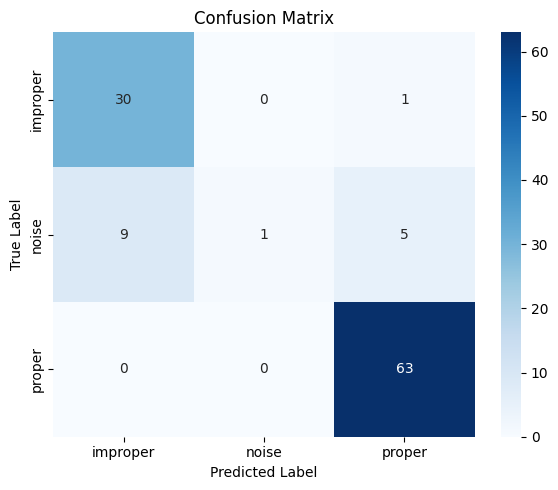

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ✅ 클래스 이름
class_names = ['improper', 'noise', 'proper']

# ✅ 혼동행렬 정의 (직접 입력한 경우)
cm = np.array([[30 ,0, 1],
 [ 9, 1, 5],
 [ 0,  0, 63]])

# ✅ 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()